# COM3025 Coursework

## Import Dataset

In [3]:
import numpy as np
from PIL import Image
import h5py
import os
from IPython.display import HTML, display

# This is for displaying the progress bar while importing data
def progress(value, max=100):
    return HTML("""
        Importing Files:
        <progress
            value='{value}'
            max='{max}',
            style='width: 50%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# Clone dataset if not already done
![[ -d COM3025 ]] || git clone https://github.com/jw01324/COM3025.git
directory = "./COM3025/Brain Tumor Dataset/Files/"
numberOfFiles = len(os.listdir(directory))

# Create dataset arrays
# Look at README for data structure
labels = np.empty((numberOfFiles,), float) 
images = np.empty((numberOfFiles, 512,512), float) 
tumorBorders = np.empty((numberOfFiles, ), dtype=object)
tumorMask = np.empty((numberOfFiles, 512,512), int) 

# Start showing progress bar
out = display(progress(0, numberOfFiles), display_id=True)

for i,filename in enumerate(os.listdir(directory)):
  # Update progress bar
  out.update(progress(i, numberOfFiles))
  
  with h5py.File(directory + filename, 'r') as file:
    labels[i] = file['cjdata']['label'][()][0][0]
    if len(file['cjdata']['image'][()]) == 512:
      images[i] = np.flipud(np.rot90(file['cjdata']['image'][()]))
      tumorMask[i] = np.flipud(np.rot90(file['cjdata']['tumorMask'][()]))
      tumorBorders[i] = file['cjdata']['tumorBorder'][()][0]
    else: # Some images are 256 so repeat each pixel
      images[i] = np.repeat(np.repeat(np.flipud(np.rot90(file['cjdata']['image'][()])), 2, axis=1), 2, axis=0)
      tumorMask[i] = np.repeat(np.repeat(np.flipud(np.rot90(file['cjdata']['tumorMask'][()])), 2, axis=1), 2, axis=0)
      tumorBorders[i] = [x*2 for x in file['cjdata']['tumorBorder'][()][0]]

images /= 255 # Get all values 0 < ? < 1         
images = np.expand_dims(images, axis=3) # Adds a dimension to images for Conv2D
print("Shape of train images", images.shape, "containing", images.dtype)
print("Shape of train labels", labels.shape, "containing", labels.dtype)

Shape of train images (3064, 512, 512, 1) containing float64
Shape of train labels (3064,) containing float64


Prepare for training

In [4]:
splitIndex = (len(images)*7)//10

x_train = images[:splitIndex]
x_test = images[splitIndex:]

labels = labels.astype(int)
one_hot_labels = np.zeros((labels.size, labels.max()))
one_hot_labels[np.arange(labels.size), labels -1] = 1

y_train = one_hot_labels[:splitIndex]
y_test = one_hot_labels[splitIndex:]

ValueError: ignored

Training the model to classify each tumour

In [8]:
from IPython.display import Image
import matplotlib.pyplot as plt
import keras
from keras.utils.vis_utils import model_to_dot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, InputLayer
from keras.layers import Conv2D, MaxPooling2D

batch_size = 32
epochs = 2

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(512,512,1)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(32, 32)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('softmax'))

opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model.summary()

Image(model_to_dot(model).create(prog='dot', format='png'))
history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 512, 512, 32)      320       
_________________________________________________________________
activation_15 (Activation)   (None, 512, 512, 32)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 510, 510, 32)      9248      
_________________________________________________________________
activation_16 (Activation)   (None, 510, 510, 32)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 7200)             

ResourceExhaustedError: ignored

Identifying tumour from cut up image and masking

In [0]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from PIL import Image
import time

%matplotlib inline

model = ResNet50(weights='imagenet')

segments_searched = 0
step = 32
#arrimg = np.array(image_rgb)
#print(image_rgb)
for y in range(0,512,step):
    for x in range(0,512,step):
        
        #cropped = images[i][y:y+step][x:x+step]
        cropped = image_rgb[x:x+step, y:y+step, :]
        #print(cropped)

        stretched = Image.fromarray(cropped)
        stretched = stretched.resize((224,224), Image.ANTIALIAS)
        stretched = np.array(stretched)
        stretched = np.expand_dims(stretched, axis=0)
        stretched = stretched.astype(np.float64)
        stretched = preprocess_input(stretched)
        
        preds = model.predict(stretched)
        top3 = str(decode_predictions(preds, top=3)[0])
        segments_searched += 1
        
        if "1" in top3 or "2" in top3 or "3" in top3:
            #print(top3)
            #print("Found a tumour")
            plt.figure()
            plt.imshow(cropped)
        
print("Total segments searched", segments_searched)

# Display images

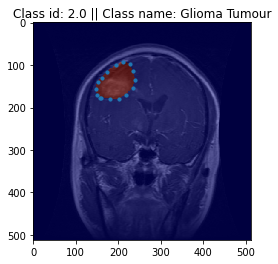

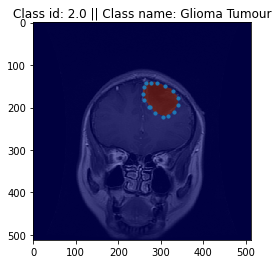

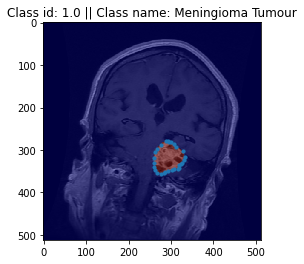

In [0]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline

def test():
  i = randint(0, len(images))

  tumorBordersX = tumorBorders[i][::2]
  tumorBordersY = tumorBorders[i][1::2]

  class_name = ""
  if (labels[i] == 1.0):
    class_name = "Meningioma Tumour"
  elif (labels[i] == 2.0):
    class_name = "Glioma Tumour"
  elif (labels[i] == 3.0):
    class_name = "Pituitary Tumour"

  plt.figure()
  plt.title("Class id: " + str(labels[i]) + " || Class name: " + class_name)
  plt.imshow(images[i], 'gray', interpolation='none')
  plt.imshow(tumorMask[i], 'jet', interpolation='none', alpha=0.5)
  plt.scatter(tumorBordersX, tumorBordersY, s=10)
  plt.show()

for i in range (0, 3):
  test()